In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

%matplotlib inline

# Load data

In [ ]:
df_result_model     = pd.read_csv("validation_results.csv")
df_result_benchmark = pd.read_csv("../data/results/benchmark_results.csv").drop("Unnamed: 0", axis=1)
df_product_categories = pd.read_csv("../data/favorita-grocery-sales-forecasting/items.csv")

# Model results

In [ ]:
df_result_model["actual"] = df_result_model.actual.apply(np.expm1)
df_result_model["adj_prediction"] = df_result_model.adj_prediction.apply(np.expm1)
df_result_model["raw_prediction"] = df_result_model.raw_prediction.apply(np.expm1)
df_result_model["incumbent_prediction"] = df_result_model.apply(
    lambda row: row.adj_prediction if abs(row.actual-row.adj_prediction) < abs(row.actual-row.raw_prediction) else row.raw_prediction, axis=1
)
df_result_model["error"] = df_result_model["actual"] - df_result_model["incumbent_prediction"]

df_result_benchmark["error"] = df_result_benchmark["actual"] - df_result_benchmark["adj_prediction"]

In [ ]:
abs(df_result_model["error"]).mean() , abs(df_result_benchmark["error"]).mean()

(18.180315864508568, 24.80519699185326)

# Make comparison dataframe

In [ ]:
df_comparison = pd.merge(df_result_model, df_result_benchmark, how="outer",
                            left_on=["horizon","item_nbr","store_nbr"],
                            right_on=["horizon","item_nbr","store_nbr"],
                             suffixes=('_model', '_benchmark'))

In [ ]:
df_comparison.item_nbr.unique()

array([ 105574,  105575,  105576, ..., 2057231, 2061404, 2081064])

In [ ]:
df_simulation = df_comparison[(df_comparison.store_nbr==1) & (df_comparison.item_nbr==2057231)][["actual_model", "incumbent_prediction", "adj_prediction_benchmark"]]
df_simulation = df_simulation.rename(columns={"actual_model": "actual",
                                              "incumbent_prediction": "model_prediction",
                                              "adj_prediction_benchmark": "benchmark_prediction"})


# starting_inventory = df_simulation.actual.mean()
model_safety_stock     = np.sqrt(((df_simulation.actual - df_simulation.model_prediction)**2).mean())
benchmark_safety_stock = np.sqrt(((df_simulation.actual - df_simulation.benchmark_prediction)**2).mean())

df_simulation["model_inventory"] = 0
df_simulation.loc[-1, "model_inventory"] = model_safety_stock

df_simulation["benchmark_inventory"] = 0
df_simulation.loc[-1, "benchmark_inventory"] = benchmark_safety_stock

df_simulation = df_simulation.sort_index()
df_simulation

,actual,model_prediction,benchmark_prediction,model_inventory,benchmark_inventory
-1,NaN,NaN,NaN,28.724913,93.693529
12960,125.491022,111.803456,28.567133,0.000000,0.000000
12961,111.132025,120.184036,29.487642,0.000000,0.000000
12962,115.481992,110.437647,29.487642,0.000000,0.000000
12963,147.848033,138.757195,29.487642,0.000000,0.000000
12964,143.786019,156.969317,29.487642,0.000000,0.000000
12965,154.033997,157.237855,29.487642,0.000000,0.000000
12966,94.144977,102.763538,29.487642,0.000000,0.000000
12967,26.826997,104.061990,29.487642,0.000000,0.000000


In [ ]:
data_matrix = df_simulation.values
for idx, row in enumerate(data_matrix):
    if idx == 0:
        continue
    else:
        demand = data_matrix[idx, 0]

        model_order_up_to     = data_matrix[idx, 1] + model_safety_stock
        benchmark_order_up_to = data_matrix[idx, 2] + benchmark_safety_stock

        model_order     = max(model_order_up_to - data_matrix[idx-1, 3], 0)
        benchmark_order = max(benchmark_order_up_to - data_matrix[idx-1, 4], 0)

        row[3] = data_matrix[idx-1, 3] + model_order - demand # max(data_matrix[idx-1, 3] + data_matrix[idx, 1] - data_matrix[idx, 0] + model_safety_stock, 0)
        row[4] = data_matrix[idx-1, 4] + benchmark_order - demand # max(data_matrix[idx-1, 4] + data_matrix[idx, 2] - data_matrix[idx, 0] + benchmark_safety_stock, 0)

df_simulation = pd.DataFrame(data_matrix, columns=["actual", "model_prediction", "benchmark_prediction", "model_inventory", "benchmark_inventory"])

df_simulation["model_stock_on_hand"] = df_simulation["model_inventory"].apply(lambda x: max(0, x))
df_simulation["model_stockout"]      = df_simulation["model_inventory"].apply(lambda x: min(0, x))
df_simulation["model_stockout"]      = (-1) * df_simulation["model_stockout"]

df_simulation["benchmark_stock_on_hand"] = df_simulation["benchmark_inventory"].apply(lambda x: max(0, x))
df_simulation["benchmark_stockout"]      = df_simulation["benchmark_inventory"].apply(lambda x: min(0, x))
df_simulation["benchmark_stockout"]      = (-1) * df_simulation["benchmark_stockout"]

df_simulation

,actual,model_prediction,benchmark_prediction,model_inventory,benchmark_inventory,model_stock_on_hand,model_stockout,benchmark_stock_on_hand,benchmark_stockout
0,NaN,NaN,NaN,28.724913,93.693529,28.724913,0,93.693529,0.000000
1,125.491022,111.803456,28.567133,15.037346,-3.230360,15.037346,0,0.000000,-3.230360
2,111.132025,120.184036,29.487642,37.776924,12.049146,37.776924,0,12.049146,0.000000
3,115.481992,110.437647,29.487642,23.680568,7.699180,23.680568,0,7.699180,0.000000
4,147.848033,138.757195,29.487642,19.634075,-24.666862,19.634075,0,0.000000,-24.666862
5,143.786019,156.969317,29.487642,41.908211,-20.604848,41.908211,0,0.000000,-20.604848
6,154.033997,157.237855,29.487642,31.928771,-30.852826,31.928771,0,0.000000,-30.852826
7,94.144977,102.763538,29.487642,37.343474,29.036194,37.343474,0,29.036194,0.000000
8,26.826997,104.061990,29.487642,105.959906,96.354175,105.959906,0,96.354175,0.000000


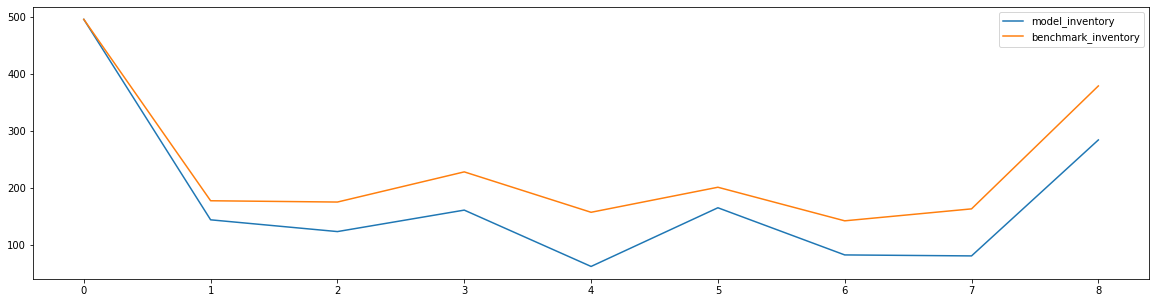

In [ ]:
df_simulation[["model_inventory","benchmark_inventory"]].plot(figsize=(20, 5))

In [ ]:
df_simulation

,actual,model_prediction,benchmark_prediction,model_inventory,benchmark_inventory,model_stock_on_hand,model_stockout,benchmark_stock_on_hand,benchmark_stockout
0,NaN,NaN,NaN,108.995799,496.275403,108.995799,0,496.275403,0
1,362.999995,370.958125,44.272882,116.953929,177.548290,116.953929,0,177.548290,0
2,369.000061,356.299502,48.010153,96.295240,175.285495,96.295240,0,175.285495,0
3,315.999944,341.023320,48.010153,134.019175,228.285612,134.019175,0,228.285612,0
4,386.999950,313.038183,48.010153,35.034032,157.285606,35.034032,0,157.285606,0
5,342.999945,372.139642,48.010153,138.135496,201.285611,138.135496,0,201.285611,0
6,402.000037,348.277394,48.010153,55.273156,142.285519,55.273156,0,142.285519,0
7,381.000051,325.553803,48.010153,53.549551,163.285505,53.549551,0,163.285505,0
8,164.999967,313.315333,48.010153,257.311165,379.285589,257.311165,0,379.285589,0


# Calculation loop

In [ ]:
from scipy.stats import norm
norm.ppf(0.95)

1.6448536269514722

In [ ]:
df_simulation_results = pd.DataFrame()

total = len(df_comparison.groupby(["store_nbr", "item_nbr"]).size().index.values)

for idx, (store, item) in enumerate(df_comparison.groupby(["store_nbr", "item_nbr"]).size().index.values):

    print("processing {} / {}".format(idx, total), end="\r")

    df_simulation = df_comparison[(df_comparison.store_nbr==store) & (df_comparison.item_nbr==item)][["actual_model", "incumbent_prediction", "adj_prediction_benchmark"]]
    df_simulation = df_simulation.rename(columns={"actual_model": "actual",
                                                  "incumbent_prediction": "model_prediction",
                                                  "adj_prediction_benchmark": "benchmark_prediction"})


    # starting_inventory = df_simulation.actual.mean()
    model_safety_stock     = np.sqrt(((df_simulation.actual - df_simulation.model_prediction)**2).mean())*norm.ppf(0.98)
    benchmark_safety_stock = np.sqrt(((df_simulation.actual - df_simulation.benchmark_prediction)**2).mean())*norm.ppf(0.95)

    df_simulation["model_inventory"] = 0
    df_simulation.loc[-1, "model_inventory"] = max(model_safety_stock, benchmark_safety_stock)

    df_simulation["benchmark_inventory"] = 0
    df_simulation.loc[-1, "benchmark_inventory"] = max(model_safety_stock, benchmark_safety_stock)

    df_simulation = df_simulation.sort_index()

    data_matrix = df_simulation.values
    for idx, row in enumerate(data_matrix):
        if idx == 0:
            continue
        else:
            demand = data_matrix[idx, 0]

            model_order_up_to     = data_matrix[idx, 1] + model_safety_stock
            benchmark_order_up_to = data_matrix[idx, 2] + benchmark_safety_stock

            model_order     = max(model_order_up_to - data_matrix[idx-1, 3], 0)
            benchmark_order = max(benchmark_order_up_to - data_matrix[idx-1, 4], 0)

            row[3] = data_matrix[idx-1, 3] + model_order - demand # max(data_matrix[idx-1, 3] + data_matrix[idx, 1] - data_matrix[idx, 0] + model_safety_stock, 0)
            row[4] = data_matrix[idx-1, 4] + benchmark_order - demand # max(data_matrix[idx-1, 4] + data_matrix[idx, 2] - data_matrix[idx, 0] + benchmark_safety_stock, 0)

    df_simulation = pd.DataFrame(data_matrix, columns=["actual", "model_prediction", "benchmark_prediction", "model_inventory", "benchmark_inventory"])

    df_simulation["model_stock_on_hand"] = df_simulation["model_inventory"].apply(lambda x: max(0, x))
    df_simulation["model_stockout"]      = (-1) * df_simulation["model_inventory"].apply(lambda x: min(0, x))

    df_simulation["benchmark_stock_on_hand"] = df_simulation["benchmark_inventory"].apply(lambda x: max(0, x))
    df_simulation["benchmark_stockout"]      = (-1) * df_simulation["benchmark_inventory"].apply(lambda x: min(0, x))

    df_simulation_results = df_simulation_results.append(df_simulation)

df_simulation_results = df_simulation_results.reset_index().rename(columns={"index": "horizon"})

In [ ]:
pd.merge(df_simulation_results, df_product_categories, how="left"

,horizon,horizon,actual,model_prediction,benchmark_prediction,model_inventory,benchmark_inventory,model_stock_on_hand,model_stockout,benchmark_stock_on_hand,benchmark_stockout
0,0,0,NaN,NaN,NaN,0.174252,0.174252,0.174252,0.0,0.174252,0.0
1,1,1,0.000000,0.016103,0.000000,0.190354,0.174252,0.190354,0.0,0.174252,0.0
2,2,2,0.000000,0.030738,0.000000,0.204990,0.174252,0.204990,0.0,0.174252,0.0
3,3,3,0.000000,0.053560,0.000000,0.227812,0.174252,0.227812,0.0,0.174252,0.0
4,4,4,0.000000,0.036290,0.000000,0.227812,0.174252,0.227812,0.0,0.174252,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14602,14602,4,49.000003,37.385290,6.293194,31.097086,39.688055,31.097086,0.0,39.688055,0.0
14603,14603,5,72.000014,37.740502,6.293194,8.452288,16.688044,8.452288,0.0,16.688044,0.0
14604,14604,6,61.999992,47.043337,6.293194,27.755144,26.688066,27.755144,0.0,26.688066,0.0
14605,14605,7,56.999995,55.803611,6.293194,41.515415,31.688063,41.515415,0.0,31.688063,0.0


,xgBoostModel,Base-Lift
horizon,,
0,5.424681e+06,5.424681e+06
1,4.617924e+06,4.592362e+06
2,4.349266e+06,4.480514e+06
3,4.477817e+06,4.799438e+06
4,4.373374e+06,4.757017e+06
5,4.179985e+06,4.691595e+06
6,3.842600e+06,4.321459e+06
7,4.533251e+06,5.011804e+06
8,6.780623e+06,7.656952e+06


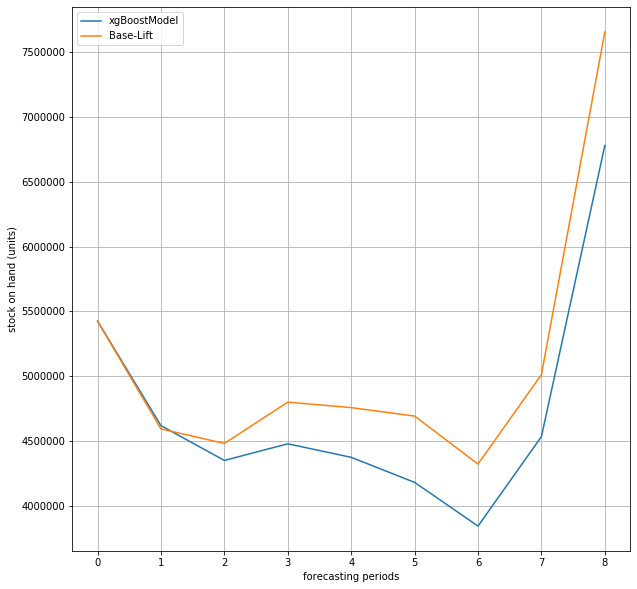

In [ ]:
df_local = df_simulation_results.groupby("horizon").agg({"model_stock_on_hand": "sum", "benchmark_stock_on_hand": "sum"})
df_local = df_local.rename(columns={"model_stock_on_hand": "xgBoostModel", "benchmark_stock_on_hand": "Base-Lift"})
ax = df_local.plot(figsize=(10, 10), grid = True)
ax.set_xlabel("forecasting periods")
ax.set_ylabel("stock on hand (units)")

# ((df_local["xgBoostModel"] - df_local["Base-Lift"])/df_local["Base-Lift"])#.mean()
df_local.to_excel("1.xlsx")

-0.4583419575521598

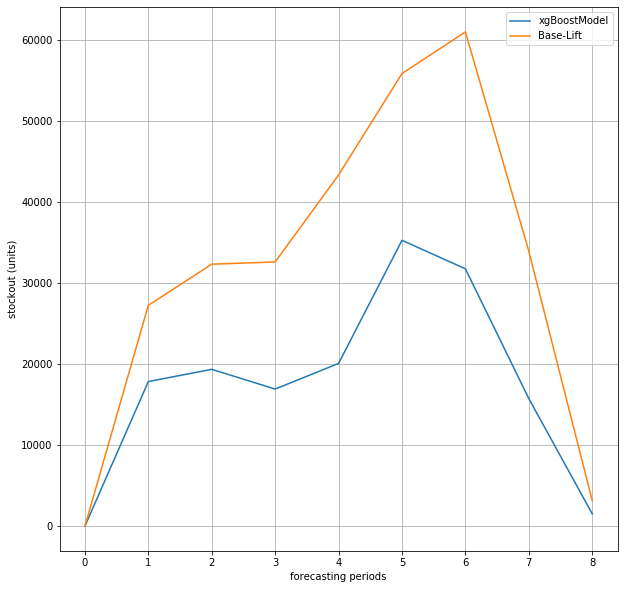

In [ ]:
df_local = df_simulation_results.groupby("horizon").agg({"model_stockout": "sum", "benchmark_stockout": "sum"})
df_local = df_local.rename(columns={"model_stockout": "xgBoostModel", "benchmark_stockout": "Base-Lift"})
ax = df_local.plot(figsize=(10, 10), grid = True)
ax.set_xlabel("forecasting periods")
ax.set_ylabel("stockout (units)")
((df_local["xgBoostModel"] - df_local["Base-Lift"])/df_local["Base-Lift"]).mean()

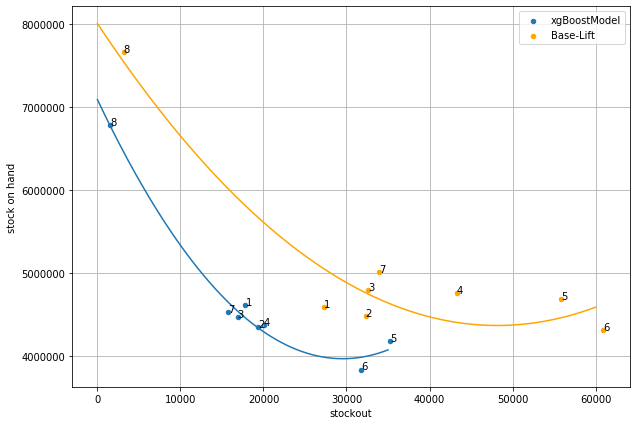

In [ ]:
df_local = df_simulation_results.groupby("horizon").agg({"model_stockout": "sum", "benchmark_stockout": "sum", "model_stock_on_hand": "sum", "benchmark_stock_on_hand": "sum"}).iloc[1:]

ax = df_local[["model_stockout", "model_stock_on_hand"]].plot.scatter(x="model_stockout", y="model_stock_on_hand", grid=True, figsize=(10, 7), label="xgBoostModel")
for idx, (x, y) in enumerate(df_local[["model_stockout", "model_stock_on_hand"]].values):
    ax.annotate(idx+1, (x,y), size=10, xytext=(0,0), ha='left', textcoords='offset points')

a, b, c = np.polyfit(df_local["model_stockout"], df_local["model_stock_on_hand"], 2)
x2 = np.arange(0, 35000)
y2 = [a*x**2 + b*x + c for x in x2]
ax.plot(x2, y2)

ax = df_local[["benchmark_stockout", "benchmark_stock_on_hand"]].plot.scatter(x="benchmark_stockout", y="benchmark_stock_on_hand", ax=ax, color = 'orange', grid=True, figsize=(10, 7), label="Base-Lift")
for idx, (x, y) in enumerate(df_local[["benchmark_stockout", "benchmark_stock_on_hand"]].values):
    ax.annotate(idx+1, (x,y), size=10, xytext=(0,0), ha='left', textcoords='offset points')

a, b, c = np.polyfit(df_local["benchmark_stockout"], df_local["benchmark_stock_on_hand"], 2)
x1 = np.arange(0, 60000)
y1 = [a*x**2 + b*x + c for x in x1]
ax.plot(x1, y1, color="orange")

ax.set_xlabel("stockout")
ax.set_ylabel("stock on hand")

ax.legend()

In [ ]:
a, b, c = np.polyfit(df_local["benchmark_stockout"], df_local["benchmark_stock_on_hand"], 2)
x1 = np.arange(0, 60000)
y1 = [a*x**2 + b*x + c for x in x1]

a, b, c = np.polyfit(df_local["model_stockout"], df_local["model_stock_on_hand"], 2)
x2 = np.arange(0, 30000)
y2 = [a*x**2 + b*x + c for x in x2]

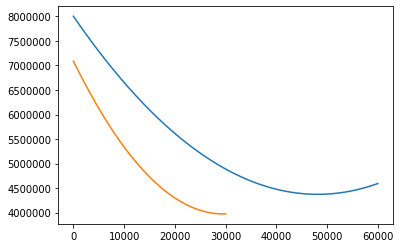

In [ ]:
ax = plt.plot(x1, y1)
ax = plt.plot(x2, y2)

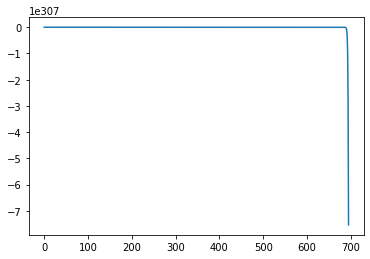

In [ ]:
plt.plot(x, y)